In [1]:
import pandas as pd 
import numpy as np
import random
import os 
import argparse
import json
import torch
import pickle
import matplotlib.pyplot as plt
from torch import nn
from attrdict import AttrDict
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from transformers import BertConfig, BertTokenizer, BertModel
from torchmetrics import R2Score
from sklearn.metrics import precision_score , recall_score , confusion_matrix, f1_score, classification_report

In [3]:
default_path = os.getcwd()
data_path = os.path.join(default_path, '../data')
base_model = os.path.join(default_path, '../base-model')
model_path = os.path.join(default_path, '../models')
config_path = os.path.join(default_path, '../config')
log_path = os.path.join(default_path, '../log')
config_file = "bert-base.json"

In [4]:
label = dict()

label[0] = '우울'
label[1] = '무기력'
label[2] = '급격한 체중(식욕)변화'
label[3] = '수면장애'
label[4] = '정서불안'
label[5] = '피로'
label[6] = '과도한 죄책감 및 무가치함'
label[7] = '인지기능저하'
label[8] = '자살충동'
label[9] = '일상'
label

{0: '우울',
 1: '무기력',
 2: '급격한 체중(식욕)변화',
 3: '수면장애',
 4: '정서불안',
 5: '피로',
 6: '과도한 죄책감 및 무가치함',
 7: '인지기능저하',
 8: '자살충동',
 9: '일상'}

In [5]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))
    
training_config.pad = 'max_length'
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [6]:
class BertDataset(Dataset):
    def __init__(self, data_file):
        self.data = data_file
    
    def __len__(self):
        return len(self.data.label)
    
    def reset_index(self):
        self.data.reset_index(inplace=True, drop=True)
    
    def __getitem__(self, idx):
        '''
        return text, label
        '''
        self.reset_index()
        text = self.data.text[idx]
        label = self.data.label[idx]
        return text, label

In [7]:
class BertRegressor(nn.Module):
    def __init__(self, config, model):
        super(BertRegressor, self).__init__()
        self.model = model
        self.linear = nn.Linear(config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 1)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.last_hidden_state[:, 0, :]
        x = self.linear(logits)
        x = self.relu(x)
        score = self.out(x)
        return score 

In [8]:
class BertProcessor():
    def __init__(self, training_config, tokenizer, truncation=True):
        self.tokenizer = tokenizer 
        self.max_len = 128
        self.pad = training_config.pad
        self.batch_size = training_config.train_batch_size
        self.truncation = truncation
    
    def convert_data(self, data_file):
        context2 = None    # single sentence classification

        batch_encoding = self.tokenizer.batch_encode_plus(
            [(data_file[idx][0], context2) for idx in range(len(data_file))],   # text, 
            max_length = self.max_len,
            padding = self.pad,
            truncation = self.truncation
        )
        
        features = []
        for i in range(len(data_file)):
            inputs = {k: batch_encoding[k][i] for k in batch_encoding}
            try:
                inputs['label'] = data_file[i][1] 
            except:
                inputs['label'] = 0 
            features.append(inputs)
        
        all_input_ids = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        all_labels = torch.tensor([f['label'] for f in features], dtype=torch.long)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        return dataset
    
    def convert_sentence(self, sent_list):   # 사용자 입력 문장 1개 -> 입력 형태 변환
        context2 = None 
        batch_encoding = self.tokenizer.batch_encode_plus(
            [(sent_list, context2)], max_length=self.max_len, padding=self.pad, truncation=self.truncation
        )
        
        features = []
        inputs = {k: batch_encoding[k][0] for k in batch_encoding}
        inputs['label'] = 0 
        features.append(inputs)

        input_id = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        input_am = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        input_tts = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        input_lb = torch.tensor([f['label'] for f in features], dtype=torch.long)
        dataset = TensorDataset(input_id, input_am, input_tts, input_lb)
        return dataset
    
    def shuffle_data(self, dataset, data_type):
        if data_type == 'train':
            return RandomSampler(dataset)
        elif data_type == 'eval' or data_type == 'test':
            return SequentialSampler(dataset)
        
    def load_data(self, dataset, sampler):
        return DataLoader(dataset, sampler=sampler, batch_size=self.batch_size)

In [9]:
class BertRegTester():
    def __init__(self, training_config, model):
        self.training_config = training_config
        self.model = model

    def get_label(self, test_dataloader, test_type):
        '''
        test_type: 0  -> Test dataset 
        test_type: 1  -> Test sentence
        '''
        preds = []
        labels = []

        for batch in test_dataloader:
            self.model.eval()   # self 안 붙이면 이상한 Output (BaseModelOutputWithPoolingAndCrossAttentions) 출력 
            batch = tuple(t.to(self.training_config.device) for t in batch)   # args.device: cuda 
            with torch.no_grad():
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                }
                outputs = self.model(**inputs)
                if test_type == 0:
                    preds.extend(outputs.squeeze().detach().cpu().numpy())
                elif test_type == 1:
                    preds.extend(outputs[0].detach().cpu().numpy())            
            label = batch[3].detach().cpu().numpy()
            labels.extend(label)
        return preds, labels 

In [10]:
class BertClsTester():
    def __init__(self, training_config, model):
        self.training_config = training_config
        self.model = model

    def get_label(self, test_dataloader, test_type):
        '''
        test_type: 0  -> Test dataset 
        test_type: 1  -> Test sentence
        '''
        preds = []
        labels = []

        for batch in test_dataloader:
            self.model.eval()
            batch = tuple(t.to(self.training_config.device) for t in batch)   # args.device: cuda 
            with torch.no_grad():
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                    "labels": batch[3]
                }
                outputs = self.model(**inputs)
                test_loss, logits = outputs[:2] 
                pred = logits.detach().cpu().numpy()
                if test_type == 0:
                    preds.extend(np.argmax(pred, axis=1))
                elif test_type == 1:
                    preds.append(np.argmax(pred))  
            label = inputs["labels"].detach().cpu().numpy()
            labels.extend(label)
        return preds, labels 
    
    def get_f1_score(self, test_dataloader):
        y_pred, y_true = self.get_label(test_dataloader)
        return round(f1_score(y_true, y_pred, average='micro'), 3) 
     
    def get_cl_report(self, test_dataloader):
        y_pred, y_true = self.get_label(test_dataloader, 0)
        cr = classification_report(y_true, y_pred).split('\n')
        clr_df = []

        for idx, line in enumerate(cr):
            clr_df.append([])
            if line == '':
                continue

            word_list = line.strip().split(' ')

            for word in word_list:
                if word != '':
                    clr_df[idx].append(word)

        clr_df[-2][0] = ' '.join([clr_df[-2][0], clr_df[-2][1]])
        clr_df[-3][0] = ' '.join([clr_df[-3][0], clr_df[-3][1]])
        clr_df[-4].insert(1, ' ')
        clr_df[-4].insert(2, ' ')
        clr_df[0].insert(0, 'index')

        clr_df[-2].pop(1)
        clr_df[-3].pop(1)
        clr_df.pop(1)
        clr_df.pop(-1)
        clr_df.pop(-4)
        clr_df = pd.DataFrame(clr_df[1:], columns=clr_df[0])
        clr_df.index = clr_df['index']

        del clr_df['index']
        return clr_df

#### Regression Model

In [12]:
X_test = pd.read_csv(os.path.join(data_path, 'bws_score_test.csv'))
X_test.head(3)

,text,text_kor,label
0,i've tried to ignore my feelings but i really ...,나는 내 감정을 무시하려고 노력했지만 정말 우울하다,14
1,to about ish and my mothers just been getting ...,나는 그녀에게 우울증이 있다고 말했고 그녀는 내가 더 일찍 일어나야 한다고 말했고 ...,10
2,at the apex we feel something at the trough we...,정점에서 우리는 무언가를 느낀다 우리는 우울하게 느끼는 무언가를 느낀다,8


In [24]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(base_model, 'bert-small'), model_max_length=128)
config = BertConfig.from_pretrained(os.path.join(base_model, 'bert-small', 'bert_config.json'))
model = BertModel.from_pretrained(os.path.join(base_model, 'bert-small'), config=config)

Some weights of the model checkpoint at F:\AuD\base-model\bert-small were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
test_processor = BertProcessor(training_config, tokenizer)

In [26]:
test_file = BertDataset(X_test)
test_dataset = test_processor.convert_data(test_file)
test_sampler = test_processor.shuffle_data(test_dataset, 'test')
test_dataloader = test_processor.load_data(test_dataset, test_sampler)

In [27]:
config.max_position_embeddings = 128

In [28]:
model_reg = BertRegressor(config, model)

In [29]:
model_name = os.path.join(model_path, 'BWS.pt')

In [32]:
# model_reg.load_state_dict(torch.load(model_name))
model_reg.load_state_dict(torch.load(model_name, map_location=torch.device('cpu')))
model_reg.to(training_config.device)

BertRegressor(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=Tru

In [33]:
bert_tester = BertRegTester(training_config, model_reg)

In [34]:
start = time.time()
y_pred, y_true = bert_tester.get_label(test_dataloader, 0)
print(f'소요 시간: {time.time() - start}')

소요 시간: 39.770607709884644


In [36]:
X_test.head(3)

,text,text_kor,label
0,i've tried to ignore my feelings but i really ...,나는 내 감정을 무시하려고 노력했지만 정말 우울하다,14
1,to about ish and my mothers just been getting ...,나는 그녀에게 우울증이 있다고 말했고 그녀는 내가 더 일찍 일어나야 한다고 말했고 ...,10
2,at the apex we feel something at the trough we...,정점에서 우리는 무언가를 느낀다 우리는 우울하게 느끼는 무언가를 느낀다,8


In [37]:
y_pred[:3] ,y_true[:3]

([10.076589, 8.749713, 7.9394817], [14, 10, 8])

In [38]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [39]:
criterion = RMSELoss

In [40]:
loss = criterion(torch.Tensor(y_pred), torch.Tensor((y_true)))
loss

tensor(2.1584)

In [41]:
r2score = R2Score()
r2score(torch.Tensor(y_pred), torch.Tensor(y_true))

tensor(0.8059)

In [42]:
X_test.text[2]

'at the apex we feel something at the trough we feel depressed'

In [108]:
test_sent = "I am so depressed today" # X_test.text[0]
test_data = test_processor.convert_sentence(test_sent)
test_sampler = test_processor.shuffle_data(test_data, 'test')
test_loader = test_processor.load_data(test_data, test_sampler)

In [54]:
start = time.time()
y_pred, y_true = bert_tester.get_label(test_loader, 1)
print(f'소요 시간: {time.time() - start}')

소요 시간: 0.10699748992919922


In [55]:
y_pred

[13.490171]

In [56]:
conv = ['hey', 'I feel very depressed', 'I feed depressed', 'I feel sad', 'I cry everyday', 'I went to school', 'I want to die']
dep_test = pd.DataFrame(conv, columns=['text'])
dep_test['label'] = 9999

In [57]:
test_file = BertDataset(dep_test)
test_dataset = test_processor.convert_data(test_file)
test_sampler = test_processor.shuffle_data(test_dataset, 'test')
test_dataloader = test_processor.load_data(test_dataset, test_sampler)

In [58]:
y_pred, y_true = bert_tester.get_label(test_dataloader, 0)

In [59]:
dep_test['label'] = [pred for pred in y_pred]
dep_test

,text,label
0,hey,-0.003593
1,I feel very depressed,14.687041
2,I feed depressed,11.882720
3,I feel sad,11.422586
4,I cry everyday,13.563297
5,I went to school,-0.003228
6,I want to die,-0.004062


#### Classification 

In [60]:
X_test = pd.read_csv(os.path.join(data_path, 'dsm_samp_test.csv'))
X_test.head(3)

,id,text,label
0,50gph3,every little insult even if it's online just h...,8
1,t3_wfhxs,"do you know why you're feeling depressed, or i...",0
2,58580,So I'm just gonna live in the countryside,9


In [73]:
X_test = X_test.sample(100)

In [74]:
X_test.label.unique()

array([7, 9, 6, 8, 3, 0, 4, 1, 2, 5], dtype=int64)

In [75]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(base_model, 'bert-mini'), model_max_length=128)
config = BertConfig.from_pretrained(os.path.join(base_model, 'bert-mini', 'bert_config.json'), num_labels=10, output_hidden_states=True)
model = BertForSequenceClassification.from_pretrained(os.path.join(base_model, 'bert-mini'), config=config)

Some weights of the model checkpoint at F:\AuD\base-model\bert-mini were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were no

In [76]:
config.max_position_embeddings = 128

In [77]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))

training_config.pad = 'max_length'
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
model.to(training_config.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, element

In [78]:
test_processor = BertProcessor(training_config, tokenizer)

In [79]:
test_file = BertDataset(X_test)
test_dataset = test_processor.convert_data(test_file)
test_sampler = test_processor.shuffle_data(test_dataset, 'test')
test_dataloader = test_processor.load_data(test_dataset, test_sampler)

In [80]:
model_name = os.path.join(model_path, 'DSM-5.pt')

In [81]:
model.load_state_dict(torch.load(model_name, map_location=torch.device('cpu')))
model.to(training_config.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, element

In [82]:
dsm_samp = X_test.copy()
dsm_samp = dsm_samp.sample(10)
dsm_samp.reset_index(inplace=True, drop=True)

In [83]:
bert_tester = BertClsTester(training_config, model)

In [84]:
start = time.time()
y_pred, y_true = bert_tester.get_label(test_dataloader, 0)
print(f'소요 시간: {time.time() - start}')

소요 시간: 3.5160703659057617


In [85]:
from torchmetrics.classification import F1Score
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassSpecificity

f1 = F1Score(task="multiclass", num_classes=len(X_test.label.unique()))
precision = MulticlassPrecision(num_classes=len(X_test.label.unique()))
recall = MulticlassRecall(num_classes=len(X_test.label.unique()))
specificity = MulticlassSpecificity(num_classes=len(X_test.label.unique()))

In [86]:
print(f'precision: {precision(torch.Tensor(y_pred), torch.Tensor(y_true))}')
print(f'recall: {recall(torch.Tensor(y_pred), torch.Tensor(y_true))}')
print(f'specificity: {specificity(torch.Tensor(y_pred), torch.Tensor(y_true))}')
print(f'f1-score: {f1(torch.Tensor(y_pred), torch.Tensor(y_true))}')

precision: 1.0000001192092896
recall: 1.0000001192092896
specificity: 1.0000001192092896
f1-score: 1.0


In [87]:
# test_sent = "I can't sleep because I have too much work to do" # X_test.text[0]
test_sent = "I am not depressed"
test_data = test_processor.convert_sentence(test_sent)
test_sampler = test_processor.shuffle_data(test_data, 'test')
test_loader = test_processor.load_data(test_data, test_sampler)

In [88]:
start = time.time()
y_pred2, y_true2 = bert_tester.get_label(test_loader, 1)
print(f'소요 시간: {time.time() - start}')

소요 시간: 0.050003767013549805


In [89]:
y_pred2

[0]

In [90]:
from sklearn.metrics import precision_score , recall_score , confusion_matrix, f1_score, classification_report

confusion_mt = pd.DataFrame(confusion_matrix(y_true, y_pred))
confusion_mt

,0,1,2,3,4,5,6,7,8,9
0,25,0,0,0,0,0,0,0,0,0
1,0,5,0,0,0,0,0,0,0,0
2,0,0,3,0,0,0,0,0,0,0
3,0,0,0,7,0,0,0,0,0,0
4,0,0,0,0,2,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,15,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,14,0
9,0,0,0,0,0,0,0,0,0,27


In [91]:
len(y_pred)

100

In [92]:
from sklearn.preprocessing import label_binarize 

y_true = label_binarize(y_true, classes=list(range(9)))
y_pred = label_binarize(y_pred, classes=list(range(9)))

In [93]:
from sklearn.metrics import roc_curve, auc

n_classes = 9
fpr = dict()
tpr = dict()
roc_auc = dict() 

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])

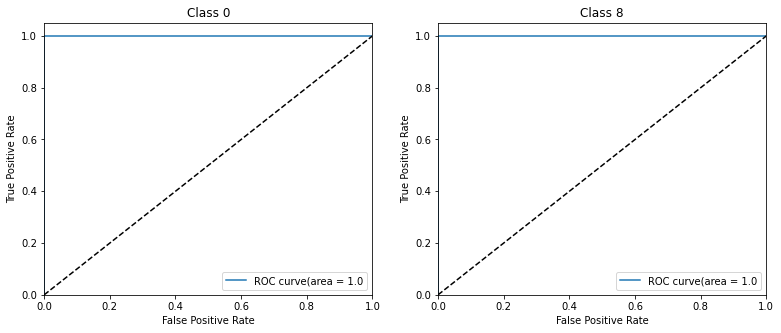

In [94]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(20, 5))
val = 0

for idx, i in enumerate(range(n_classes)):
    if idx == 0 or idx == 8 or idx == 9: 
        plt.subplot(131+val) 
        plt.plot(fpr[i], tpr[i], label = f'ROC curve(area = {round(roc_auc[i], 2)}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate') 
        plt.ylabel('True Positive Rate')
        plt.title(f'Class {idx}')
        plt.legend(loc='lower right')
        val += 1
plt.show()

#### 가상 대화 예측 

In [97]:
text = 'hey'
conv = pd.DataFrame([text], columns=['text'])
conv['speaker'] = 'user'
conv = conv[['speaker', 'text']]

In [99]:
conv.loc[1] = ['chatbot', 'hello, nice to meet you']
conv.loc[2] = ['user', 'who are you ?']
conv.loc[3] = ['chatbot', 'I am a psychological counseling chatbot']
conv.loc[4] = ['user', 'ah-huh']
conv.loc[5] = ['chatbot', 'how are you ?']
conv.loc[6] = ['user', 'I am very depressed today']
conv.loc[7] = ['chatbot', 'what is the matter ?'] 
conv.loc[8] = ['user', 'I do not know why but just depressed']
conv.loc[9] = ['chatbot', 'when you are depressed, you have to move']
conv.loc[10] = ['user', 'also I lost 30 pounds and I feel lethargic']
conv.loc[11] = ['chatbot', 'that sounds too bad']
conv.loc[12] = ['user', 'Anyway, thanks for listening']
conv.loc[13] = ['chatbot', 'yes, see you next time']
conv.head(3)

,speaker,text
0,user,hey
1,chatbot,"hello, nice to meet you"
2,user,who are you ?


In [100]:
user_idx = [idx for idx in range(len(conv)) if idx % 2 == 0]
user_conv = conv.loc[user_idx]
user_conv['label'] = 0

In [101]:
conv_file = BertDataset(user_conv)
conv_dataset = test_processor.convert_data(conv_file)
conv_sampler = test_processor.shuffle_data(conv_dataset, 'test')
conv_dataloader = test_processor.load_data(conv_dataset, conv_sampler)

In [102]:
cls_tester = BertClsTester(training_config, model)

In [103]:
y_pred, y_true = bert_tester.get_label(conv_dataloader, 0)

In [104]:
user_conv['label'] = y_pred
# user_conv.columns = ['text' ,'label_9']

In [105]:
label[0] = 'depressed'
label[1] = 'lethargic'
label[2] = 'appetite/weight problem'
label[3] = 'sleep disorder'
label[4] = 'emotional instability'
label[5] = 'fatigue'
label[6] = 'excessive guilt/worthlessness'
label[7] = 'cognitive problems'
label[8] = 'suicidal thoughts'
label[9] = 'daily'
label

{0: 'depressed',
 1: 'lethargic',
 2: 'appetite/weight problem',
 3: 'sleep disorder',
 4: 'emotional instability',
 5: 'fatigue',
 6: 'excessive guilt/worthlessness',
 7: 'cognitive problems',
 8: 'suicidal thoughts',
 9: 'daily'}

In [106]:
user_conv

,speaker,text,label
0,user,hey,9
1,user,who are you ?,9
2,user,ah-huh,9
3,user,I am very depressed today,0
4,user,I do not know why but just depressed,0
5,user,also I lost 30 pounds and I feel lethargic,2
6,user,"Anyway, thanks for listening",9


In [107]:
user_conv.label = user_conv.label.apply(lambda x: label[x])
# user_conv.label_10 = user_conv.label_10.apply(lambda x: label[x])
user_conv

,speaker,text,label
0,user,hey,daily
1,user,who are you ?,daily
2,user,ah-huh,daily
3,user,I am very depressed today,depressed
4,user,I do not know why but just depressed,depressed
5,user,also I lost 30 pounds and I feel lethargic,appetite/weight problem
6,user,"Anyway, thanks for listening",daily
